In [2]:
# ===============================
# 2. Calculate RSI
# ===============================
import ta
df["RSI"] = ta.momentum.RSIIndicator(df["close"], window=14).rsi()


In [3]:
# ===============================
# 3. MACD Calculation
# ===============================
df["EMA12"] = df["close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["Histogram"] = df["MACD"] - df["Signal"]


In [4]:
import talib
df["DEMA9"] = talib.DEMA(df["close"].values, timeperiod=9)

In [5]:
# ------------------------------
# 2. Calculate SMA (3 closes)
# ------------------------------
sma_window = 3
df['SMA'] = ta.trend.sma_indicator(df['close'], window=sma_window)


In [6]:
# ------------------------------
# 2. Compute TSI
# ------------------------------
def compute_tsi(close, r1=25, r2=13):
    delta = close.diff()
    ema1 = delta.ewm(span=r1, adjust=False).mean()
    ema2 = ema1.ewm(span=r2, adjust=False).mean()

    abs_delta = delta.abs()
    abs_ema1 = abs_delta.ewm(span=r1, adjust=False).mean()
    abs_ema2 = abs_ema1.ewm(span=r2, adjust=False).mean()

    tsi = 100 * (ema2 / abs_ema2)
    return tsi

df['TSI'] = compute_tsi(df['close'])


In [7]:
# ========================
# 2. Stochastic Oscillator
# ========================
period = 14
smooth_k = 3
smooth_d = 3

lowest_low = df["low"].rolling(period).min()
highest_high = df["high"].rolling(period).max()

df["%K"] = 100 * (df["close"] - lowest_low) / (highest_high - lowest_low)
df["%K"] = df["%K"].rolling(smooth_k).mean()
df["%D"] = df["%K"].rolling(smooth_d).mean()


In [8]:
df.dropna(inplace=True)

In [9]:
import numpy as np

def adaptive_triple_barrier_labeling(df, mult=1, max_period=10):
    """
    Adaptive triple-barrier method based on volatility.
    - mult: how many standard deviations to use for barrier width
    - max_period: candles to look ahead
    """
    df = df.copy()
    df['vol'] = df['close'].pct_change().rolling(20).std()
    labels = np.ones(len(df), dtype=int)
    close = df['close'].values

    for i in range(len(df) - max_period):
        if np.isnan(df['vol'].iloc[i]):
            continue

        # Dynamic upper/lower barriers based on volatility
        upper = close[i] * (1 + mult * df['vol'].iloc[i])
        lower = close[i] * (1 - mult * df['vol'].iloc[i])
        future_prices = close[i+1:i+max_period+1]

        if np.any(future_prices >= upper):
            labels[i] = 2
        elif np.any(future_prices <= lower):
            labels[i] = 0
        else:
            labels[i] = 1

    df['Label'] = labels
    return df


In [16]:
df = adaptive_triple_barrier_labeling(df, mult=2, max_period=30)
print(df["Label"].value_counts())


Label
2    543
0    326
1    114
Name: count, dtype: int64


In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

FEATURES = ['RSI', 'EMA12', 'EMA26', 'MACD', 'Signal', 'Histogram', 'DEMA9', 'SMA', 'TSI', '%K', '%D']

X = df[FEATURES].values
y = df["Label"].values

# ===============================
# 2. Scale features
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler_1m.pkl")  # save scaler for later predictions


['scaler_1m.pkl']

In [19]:
def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.int64)

window_size = 10
X_seq, y_seq = create_sequences(X_scaled, df['Label'].values, window_size)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train.cpu())
weights = compute_class_weight('balanced', classes=classes, y=y_train.cpu().numpy())
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)


In [23]:
import torch.nn as nn
import torch.optim as optim

class CryptoLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(CryptoLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

input_dim = len(FEATURES)
hidden_dim = 128
num_layers = 4
output_dim = 3

model = CryptoLSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
epochs = 100
batch_size = 32

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    running_loss = 0

    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/(X_train.size(0)//batch_size):.4f}")


Epoch 1/100, Loss: 1.1297
Epoch 2/100, Loss: 0.9855
Epoch 3/100, Loss: 0.8950
Epoch 4/100, Loss: 0.8515
Epoch 5/100, Loss: 0.8608
Epoch 6/100, Loss: 0.8060
Epoch 7/100, Loss: 0.8143
Epoch 8/100, Loss: 0.8355
Epoch 9/100, Loss: 0.8724
Epoch 10/100, Loss: 0.7928
Epoch 11/100, Loss: 0.7681
Epoch 12/100, Loss: 0.7670
Epoch 13/100, Loss: 0.7445
Epoch 14/100, Loss: 0.8386
Epoch 15/100, Loss: 0.7845
Epoch 16/100, Loss: 0.7937
Epoch 17/100, Loss: 0.7833
Epoch 18/100, Loss: 0.7100
Epoch 19/100, Loss: 0.6949
Epoch 20/100, Loss: 0.6501
Epoch 21/100, Loss: 0.6848
Epoch 22/100, Loss: 0.6831
Epoch 23/100, Loss: 0.6874
Epoch 24/100, Loss: 0.6691
Epoch 25/100, Loss: 0.6493
Epoch 26/100, Loss: 0.6280
Epoch 27/100, Loss: 0.6012
Epoch 28/100, Loss: 0.6182
Epoch 29/100, Loss: 0.5846
Epoch 30/100, Loss: 0.5610
Epoch 31/100, Loss: 0.5188
Epoch 32/100, Loss: 0.5718
Epoch 33/100, Loss: 0.5775
Epoch 34/100, Loss: 0.5274
Epoch 35/100, Loss: 0.4985
Epoch 36/100, Loss: 0.6526
Epoch 37/100, Loss: 0.5547
Epoch 38/1

In [25]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predictions = torch.argmax(outputs, dim=1)
    accuracy = (predictions == y_test).float().mean()
    print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.2513


In [26]:
torch.save(model.state_dict(), "greg_tech_8.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# Example feature values
example_features = {
    'RSI': 40.231328, 
    'EMA12': 117510.625832,
    'EMA26': 117522.059487,
    'MACD': -11.433655,
    'Signal':36.277050,
    'Histogram':-47.710705,
    'DEMA9':117395.915076,
    'SMA':117365.470000,
    'TSI': 41.065534,
    '%K':29.053022,
    '%D':42.278097
}

FEATURES = ['RSI', 'EMA12', 'EMA26', 'MACD', 'Signal', 'Histogram', 'DEMA9', 'SMA', 'TSI', '%K', '%D']

# Scale features
X_scaled = scaler.transform(df[FEATURES].values)


In [28]:
window_size = 10
predictions = [1]*window_size  # first window_size rows cannot be predicted, assume "No Reversal"

for i in range(window_size, len(X_scaled)):
    X_input = torch.tensor(X_scaled[i-window_size:i], dtype=torch.float32).unsqueeze(0)  # (1, seq_len, features)
    with torch.no_grad():
        output = model(X_input)
        pred_label = torch.argmax(output, dim=1).item()
        predictions.append(pred_label)

df["Predicted"] = predictions

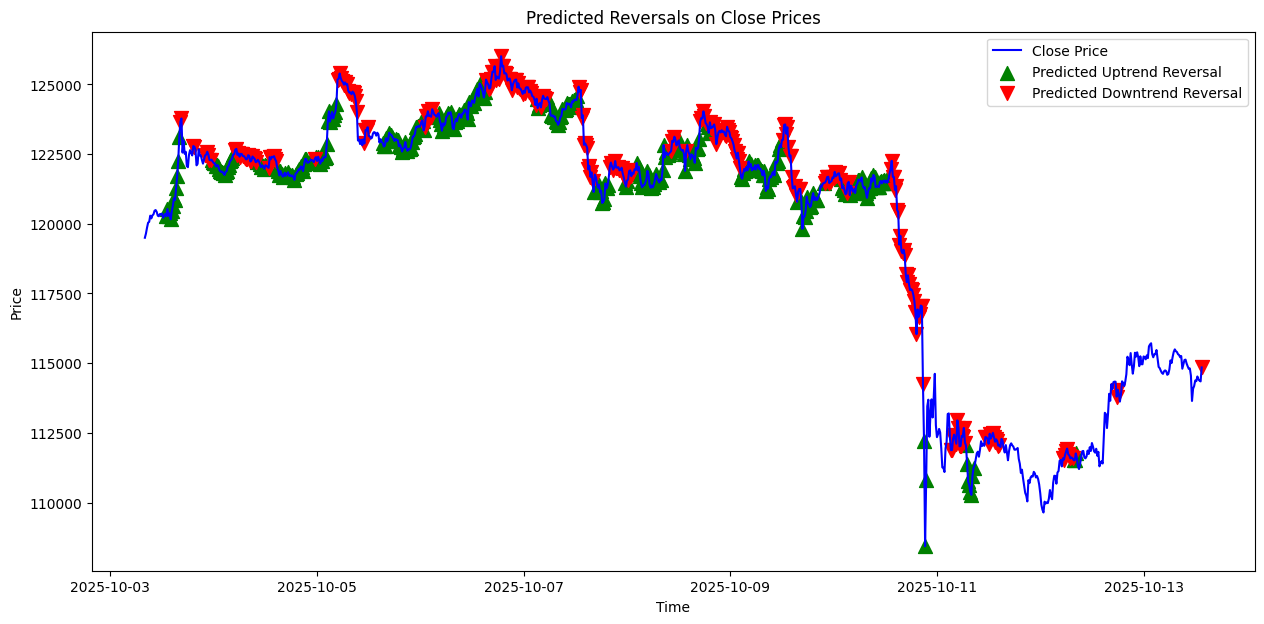

In [29]:
# ===============================
# 5. Plot Close prices with predicted reversals
# ===============================
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(df.index, df["close"], label="Close Price", color="blue")

# Uptrend reversals (label=2)
plt.scatter(df.index[df["Predicted"]==2], df["close"][df["Predicted"]==2],
            marker="^", color="green", s=100, label="Predicted Uptrend Reversal")

# Downtrend reversals (label=0)
plt.scatter(df.index[df["Predicted"]==0], df["close"][df["Predicted"]==0],
            marker="v", color="red", s=100, label="Predicted Downtrend Reversal")

plt.title("Predicted Reversals on Close Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()